## Introduction

This Notebook shows how to perform a quick analysis on simple time series by using basic Pandas and Seaborn commands to generate heatmaps.
The similar techniques can be used on any dataset containing just a date and value columns (number of sales, users accesses…).  
I hope the same steps can be useful when analyzing any time series dataset.

Let's start by importing the needed libraries, also setting retina resolution for plots and ggplot style.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import calendar
import matplotlib.style as style
import missingno as msno

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

style.use('ggplot')

### Dataset  

I'm using a dataset downloaded from the National Centers for Environmental Information (NCEI), the data is in the public domain and can be used freely.  
In case using the same dataset or generating a new one from NCEI you need to cite the origin.  
The Dataset covers each day from 2010 to 2019 and the station used is located at Heathrow Airport in London.

**DATE**: is the year of the record (4 digits) followed by month (2 digits) and day (2 digits).  
**PRCP**: Precipitation (mm)  
**TAVG**: Average temperature (°C)  

In [54]:
df = pd.read_csv('HeathrowMeteo2010-2019.csv', 
                               usecols=['DATE', 'PRCP', 'TAVG'], parse_dates=['DATE'])
#df['DATE'] = df['DATE'].astype('datetime64[ns]') # needed if date format is not standard
df.columns = ['date', 'precipitation', 'avg_temp']
df.sample(3)

,date,precipitation,avg_temp
2551,2017-01-16,5.3,5.6
1277,2013-07-01,0.0,16.6
3209,2018-11-05,0.0,11.3


In [55]:
df.dtypes

date             datetime64[ns]
precipitation           float64
avg_temp                float64
dtype: object

In [56]:
len(df)

3621

Let's check if there are missing values

In [57]:
df.isnull().sum()

date              0
precipitation    30
avg_temp          0
dtype: int64

In [58]:
round(df.isnull().mean() * 100, 2)

date             0.00
precipitation    0.83
avg_temp         0.00
dtype: float64

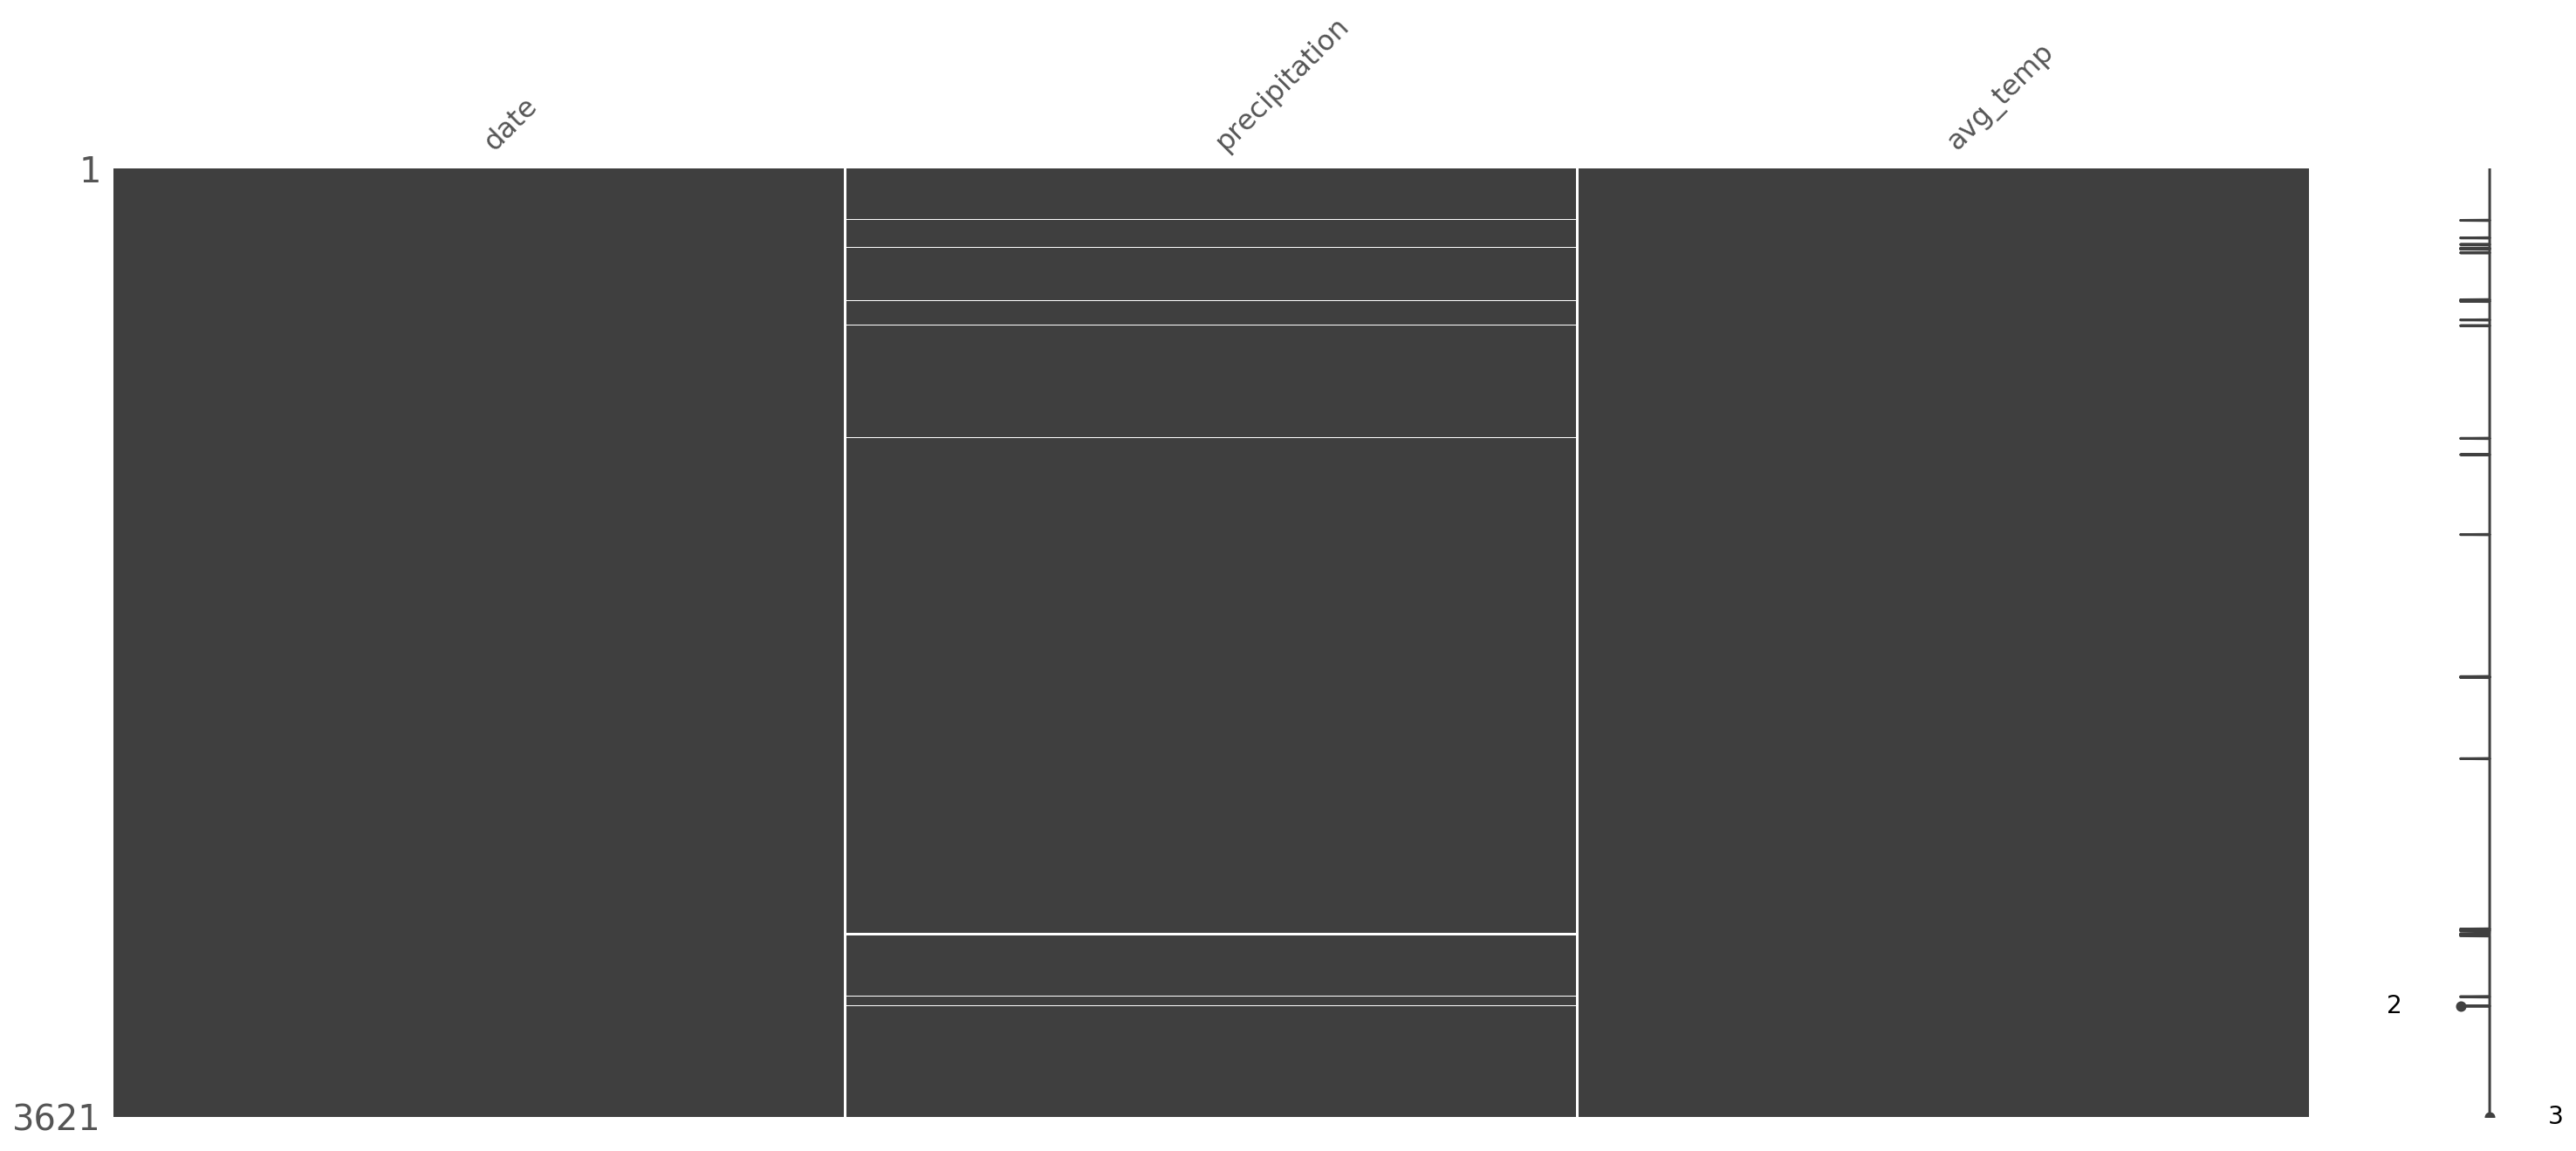

In [59]:
_ = msno.matrix(df)

In this case we will fill the null values with 0.0 (in this case meaning no rain), this is to make the rest of the analysis simpler (like when summing up) but this may change depending on your dataset.

In [60]:
df['precipitation'].fillna(0, inplace=True)

We also want to check if there are missing days in the range

In [61]:
print(f"Data Available from {df.date.min()} to {df.date.max()}")

Data Available from 2010-01-01 00:00:00 to 2019-12-31 00:00:00


In [62]:
idx = pd.date_range(df.date.min(), df.date.max())
print(f"Days present {len(df)} out of {len(idx)}")

Days present 3621 out of 3652


Some days are missing, let's create a DataFrame to visualize them.

In [63]:
pd.DataFrame(data=idx.difference(df.date), columns=['dates']).sample(3)

,dates
3,2015-04-11
28,2019-05-17
23,2018-11-19


According to the MET Office a day can be considered dry if precipitation is less than 1mm.  
Let's see what is the percentage of dry days in the entire dataset.

In [64]:
MIN_PRECIPITATION_MM_DRY = 1.0

In [65]:
round((len(df[df['precipitation'] < MIN_PRECIPITATION_MM_DRY]) / len(df)) * 100, 2)

70.81

Find day with the highest precpitation.

In [66]:
df[df.precipitation == df.precipitation.max()][['date', 'precipitation']]

,date,precipitation
2043,2015-08-27,48.0


And highest temperature

In [67]:
df[df.avg_temp == df.avg_temp.max()][['date', 'avg_temp']]

,date,avg_temp
3461,2019-07-25,28.6


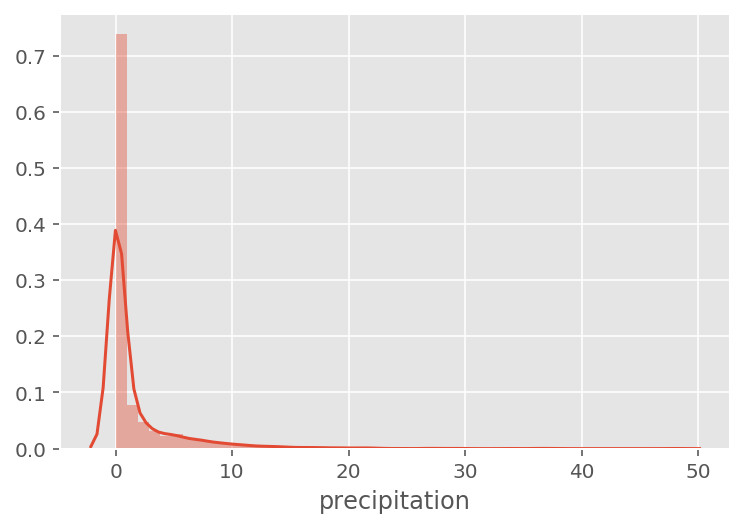

In [68]:
sns.distplot(df.precipitation)

In order to create the needed visualizations it can be useful to augment the dataframe with additional columns representing date infos.  
This step is not strictly needed because we could just use the same methods when later grouping.

In [71]:
df['month'] = df.date.dt.month
df['year'] = df.date.dt.year
df['day'] = df.date.dt.day
df['weekdayName'] = df.date.dt.day_name() # df.date.dt.weekday_name on older Pandas
df['weekday'] = df.date.dt.weekday
df['week'] = df.date.dt.week
df['weekend'] = df.date.dt.weekday // 5 == 1

In [72]:
df['raining'] = df['precipitation'].gt(MIN_PRECIPITATION_MM_DRY).astype('int')

In [73]:
df.sample(3)

,date,precipitation,avg_temp,month,year,day,weekdayName,weekday,week,weekend,raining
3263,2019-01-04,0.0,3.1,1,2019,4,Friday,4,1,False,0
850,2012-04-30,5.6,13.6,4,2012,30,Monday,0,18,False,1
3157,2018-09-14,0.0,13.9,9,2018,14,Friday,4,37,False,0


We could create a heatmap representing the average precipitation for every month in the dataset.  
To do so we can use the pivot_table function:

In [74]:
all_month_year_df = pd.pivot_table(df, values="precipitation",index=["month"],
                                   columns=["year"],
                                   fill_value=0,
                                   margins=True)
named_index = [[calendar.month_abbr[i] if isinstance(i, int) else i for i in list(all_month_year_df.index)]]
all_month_year_df = all_month_year_df.set_index(named_index)
all_month_year_df

year,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,All
Jan,1.687097,2.506452,0.996774,1.309677,4.783871,1.964516,2.383871,1.867742,1.329032,0.929032,1.975806
Feb,3.196429,1.535714,0.579310,1.389286,3.671429,1.457143,1.572414,1.450000,0.989286,1.346429,1.714184
Mar,1.641935,0.464516,0.561290,1.554839,1.041935,0.835484,2.367742,0.887097,2.680645,1.654839,1.369032
Apr,0.726667,0.086667,2.926667,1.130000,1.880000,0.922222,1.593333,0.123333,2.156667,0.426667,1.217921
May,0.764516,0.806452,0.835484,1.332258,2.841935,0.819355,1.567742,2.151613,1.964516,1.337037,1.443464
Jun,0.250000,2.643333,3.390000,0.400000,1.356667,0.423333,3.513333,1.546667,0.016667,2.736667,1.627667
Jul,0.548387,1.561290,1.835484,0.819355,1.622581,2.325806,0.541935,2.932258,0.483871,1.632258,1.430323
Aug,3.019355,2.154839,1.141935,1.067742,3.174194,3.412903,0.700000,1.858065,1.538710,1.100000,1.916774
Sep,1.033333,1.160000,1.230000,1.676667,0.360000,2.056667,1.316667,1.946667,0.563333,1.856667,1.320000
Oct,2.000000,0.409677,2.454839,1.596774,2.480645,1.296774,0.800000,0.448387,1.845161,3.125806,1.645806


In [75]:
def plot_heatmap(df, title):
    plt.figure(figsize = (14, 10))
    ax = sns.heatmap(df, cmap='RdYlGn_r',
                     robust=True,
                     fmt='.2f', annot=True,
                     linewidths=.5, annot_kws={'size':11},
                     cbar_kws={'shrink':.8, 'label':'Precipitation (mm)'})
    
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=10)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=0, fontsize=10)
    plt.title(title, fontdict={'fontsize':18}, pad=14);

robust or vmin, vmax

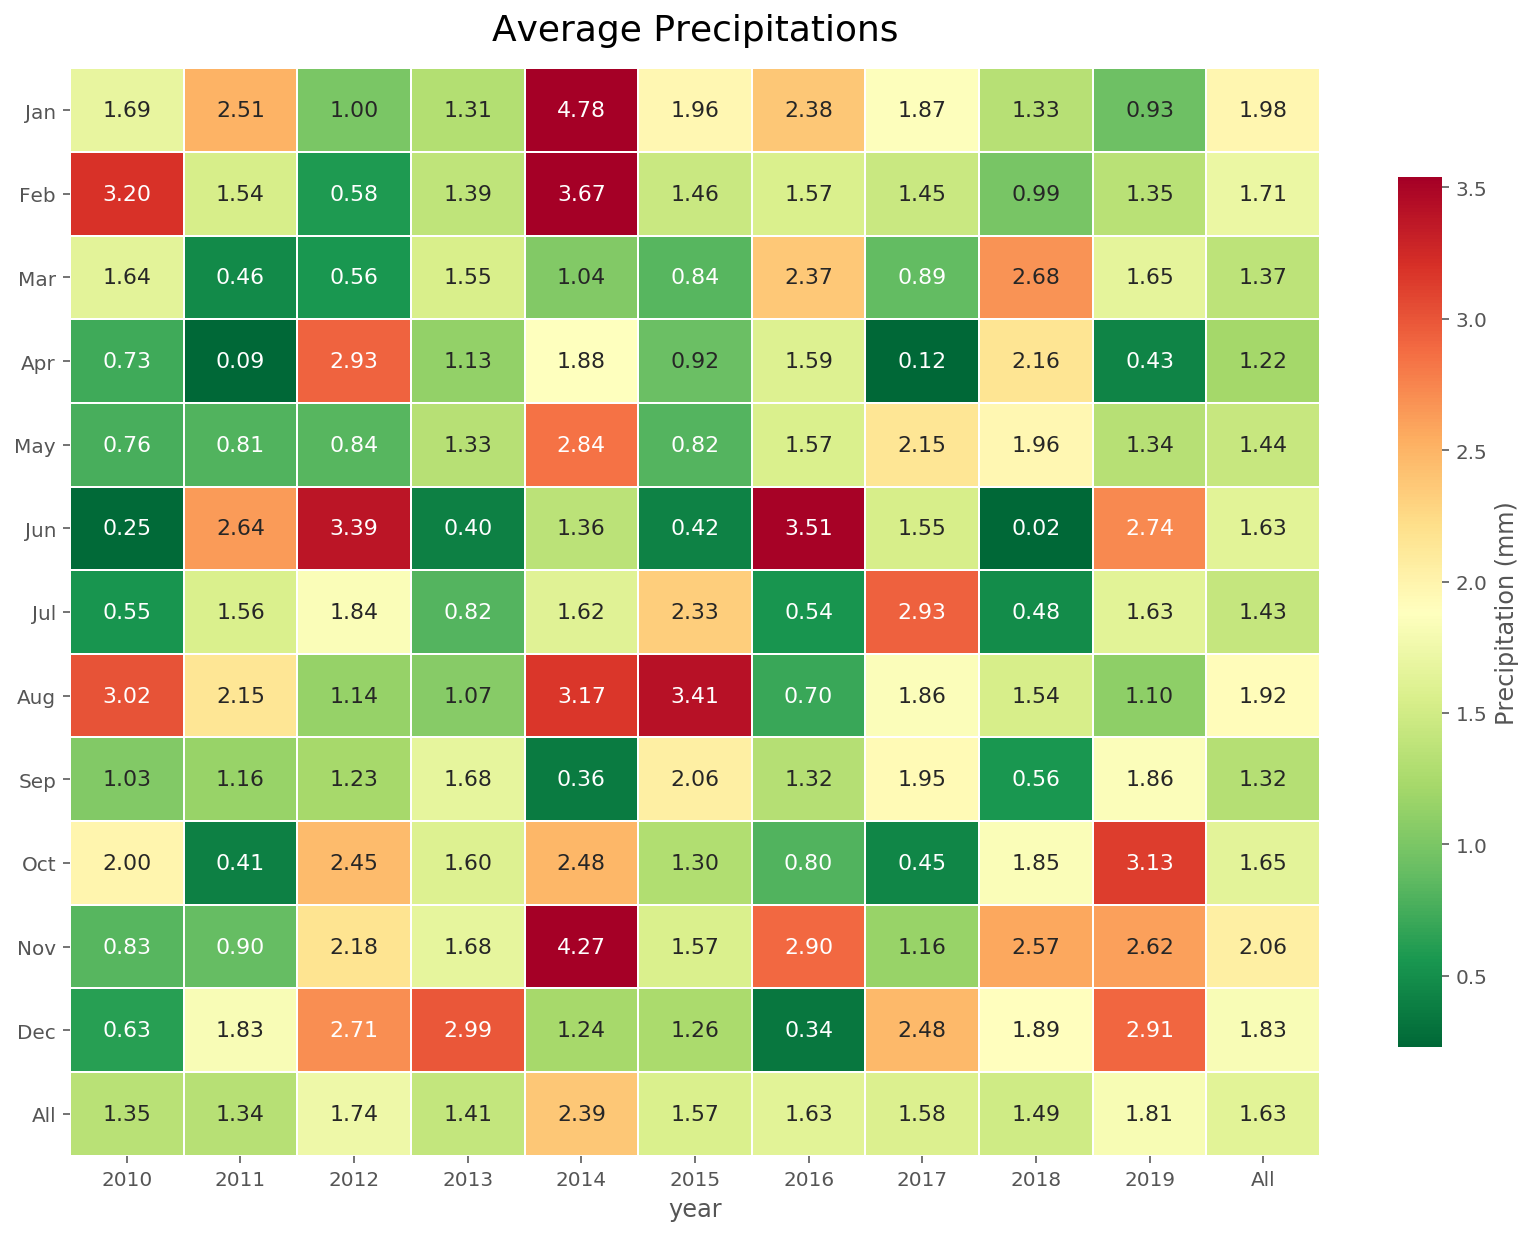

In [76]:
plot_heatmap(all_month_year_df, 'Average Precipitations')

By changing the aggfunc on pivot_table creation we can have a different aggregation, for instance we can use aggfunc=np.sum to calculate the total amount of rainfall per month.

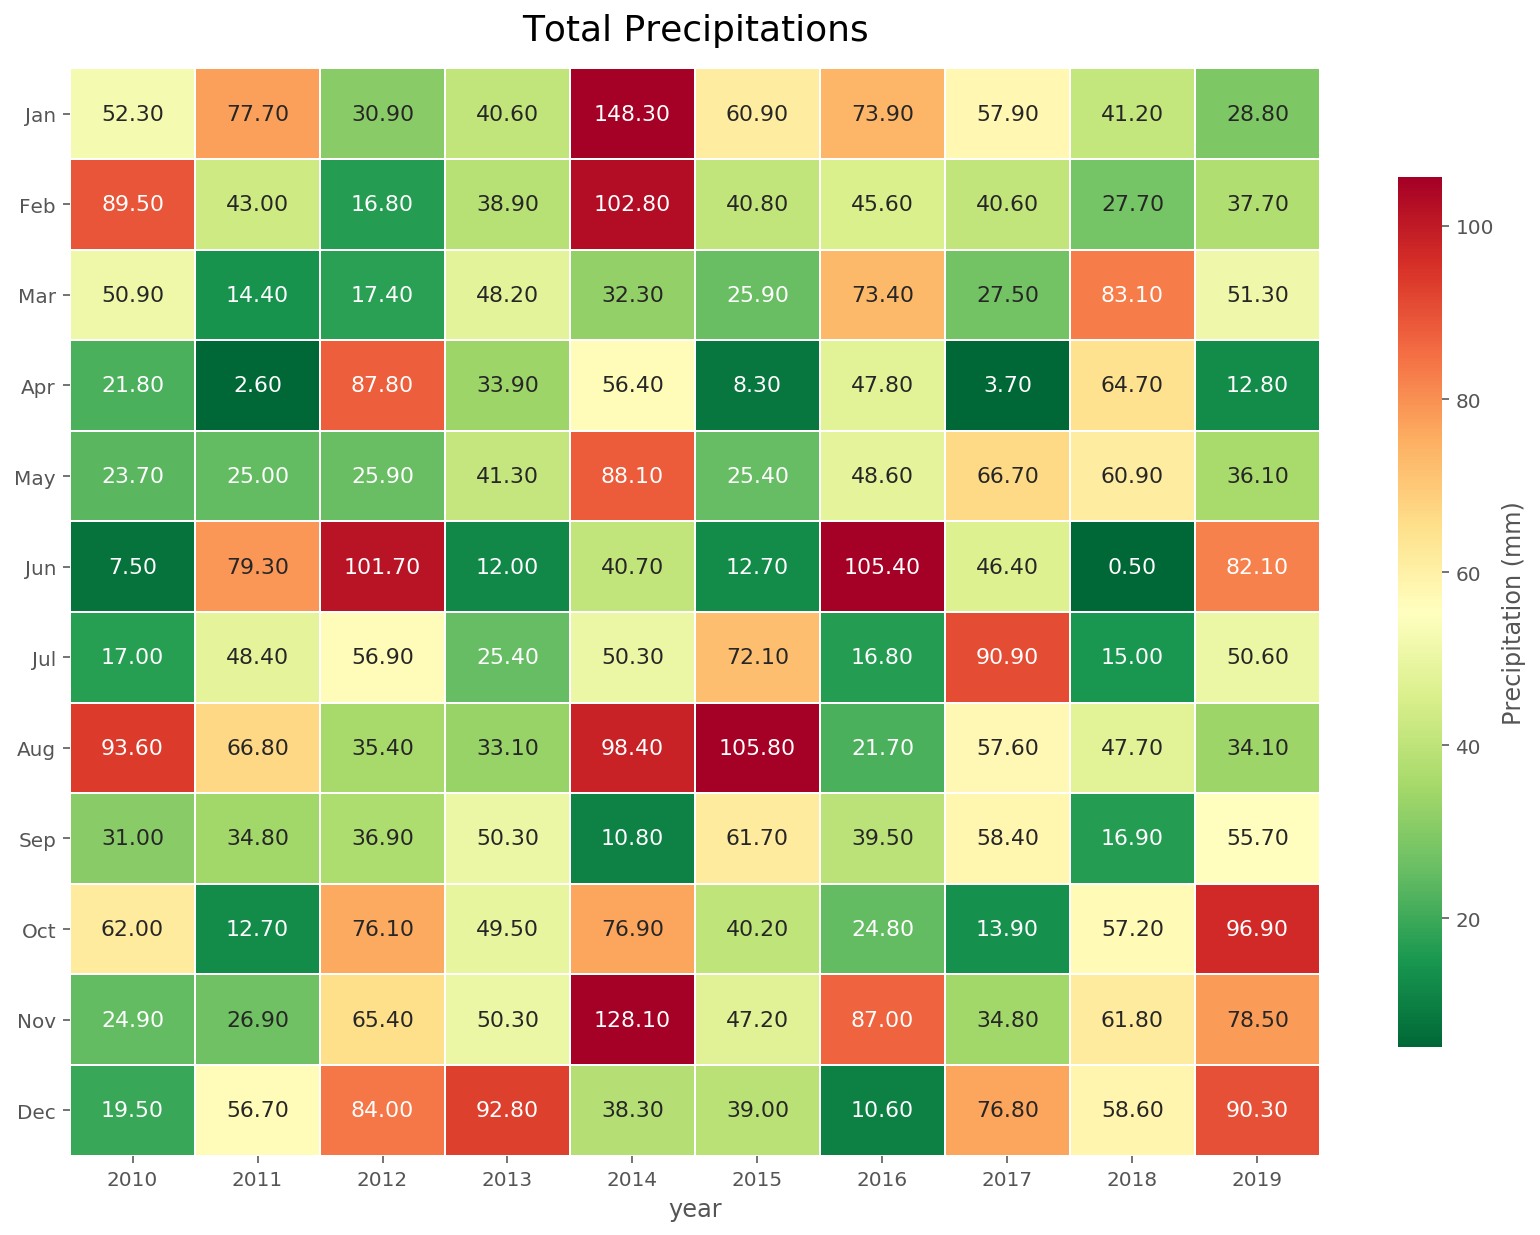

In [77]:
all_month_year_sum_df = pd.pivot_table(df, values="precipitation",index=["month"], columns=["year"], aggfunc=np.sum, fill_value=0)
all_month_year_sum_df = all_month_year_sum_df.set_index([[calendar.month_abbr[i] if isinstance(i, int) else i for i in list(all_month_year_sum_df.index)]])
plot_heatmap(all_month_year_sum_df, 'Total Precipitations')

And if we wanted to calculate the average amount of rainfall per weekday we just need to change index.

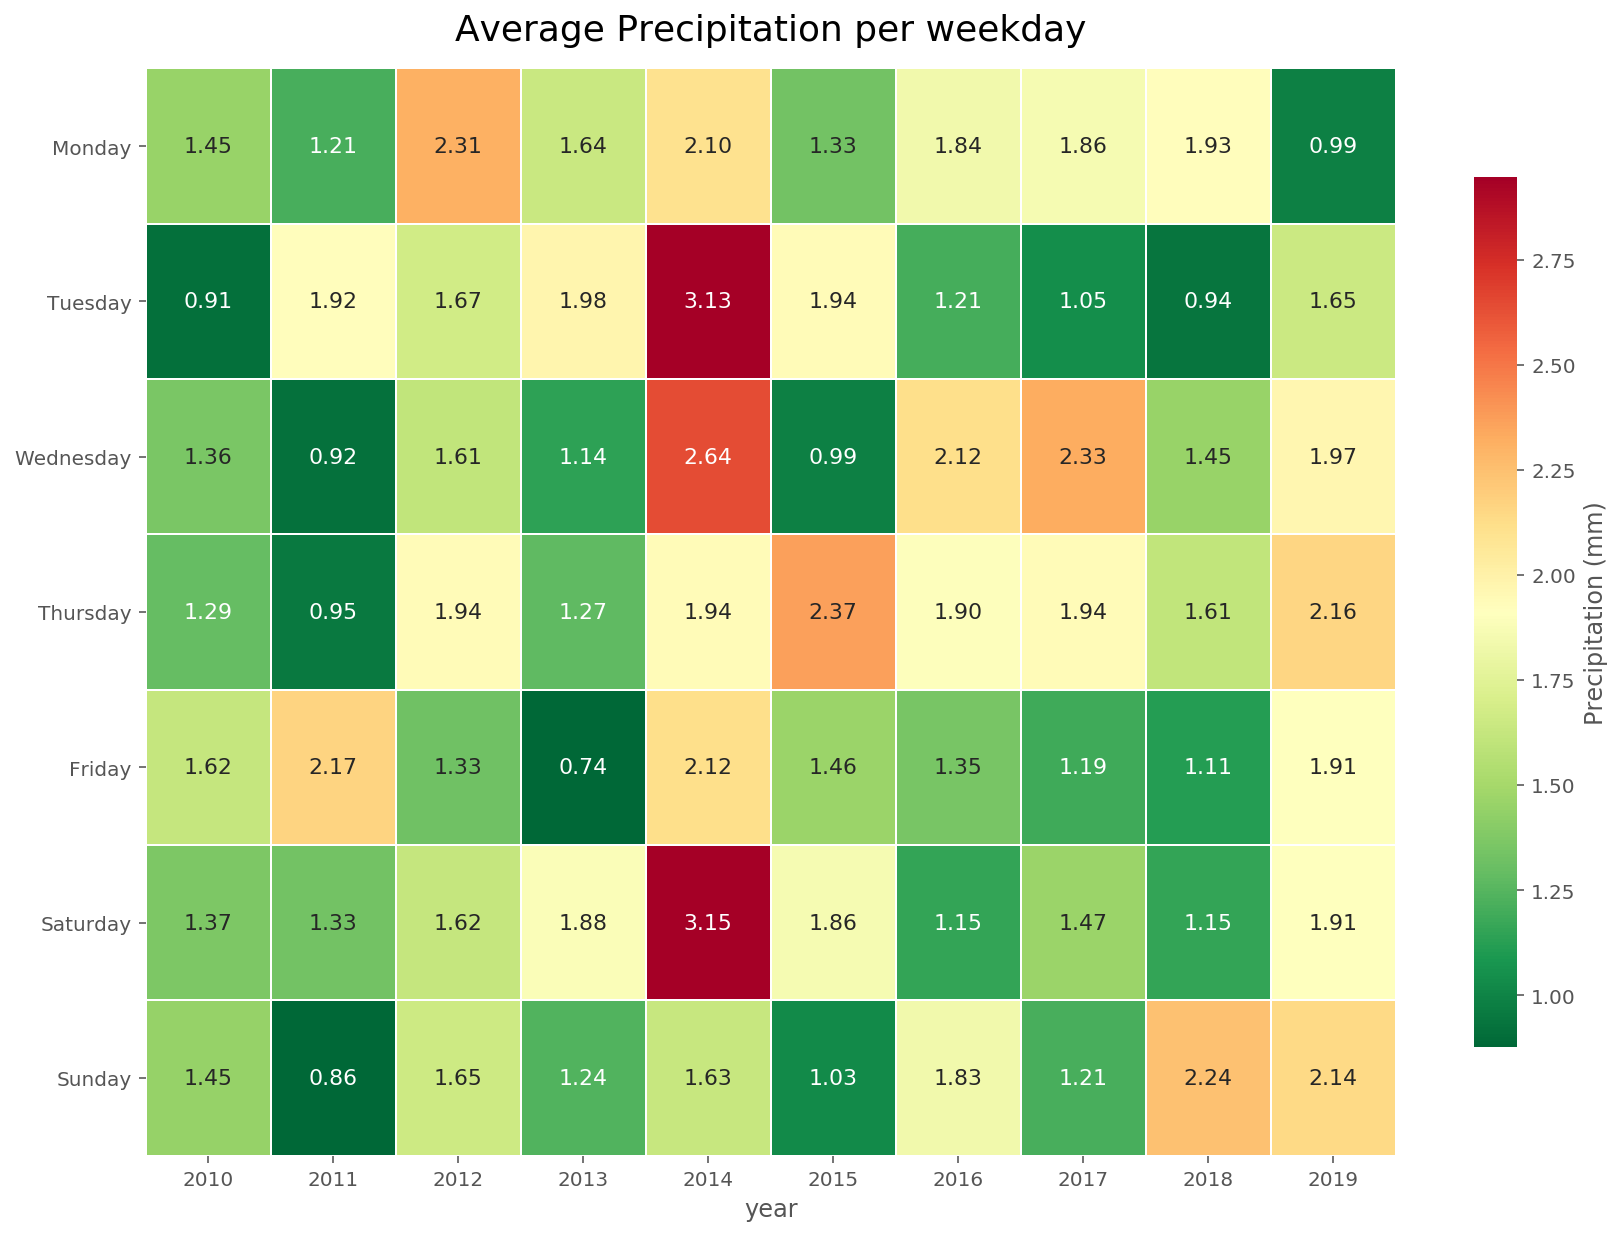

In [78]:
all_weekday_year_df = pd.pivot_table(df, values="precipitation",index=["weekday"], columns=["year"], fill_value=0.0)
all_weekday_year_df = all_weekday_year_df.set_index([[calendar.day_name[i] for i in list(all_weekday_year_df.index)]])
plot_heatmap(all_weekday_year_df, 'Average Precipitation per weekday')

The aggfunc can be a custom function, it could be interesting to calculate the percentage of days in the month with rain.

In [79]:
all_month_year_percentage_df = pd.pivot_table(df, values="precipitation",index=["month"], columns=["year"],
                                              aggfunc=lambda x: (x>MIN_PRECIPITATION_MM_DRY).sum()/len(x),
                                              fill_value=0,
                                              margins=True)
all_month_year_percentage_df = all_month_year_percentage_df.set_index([[calendar.month_abbr[i] if isinstance(i, int)
                                                                        else i for i in list(all_month_year_percentage_df.index)]])

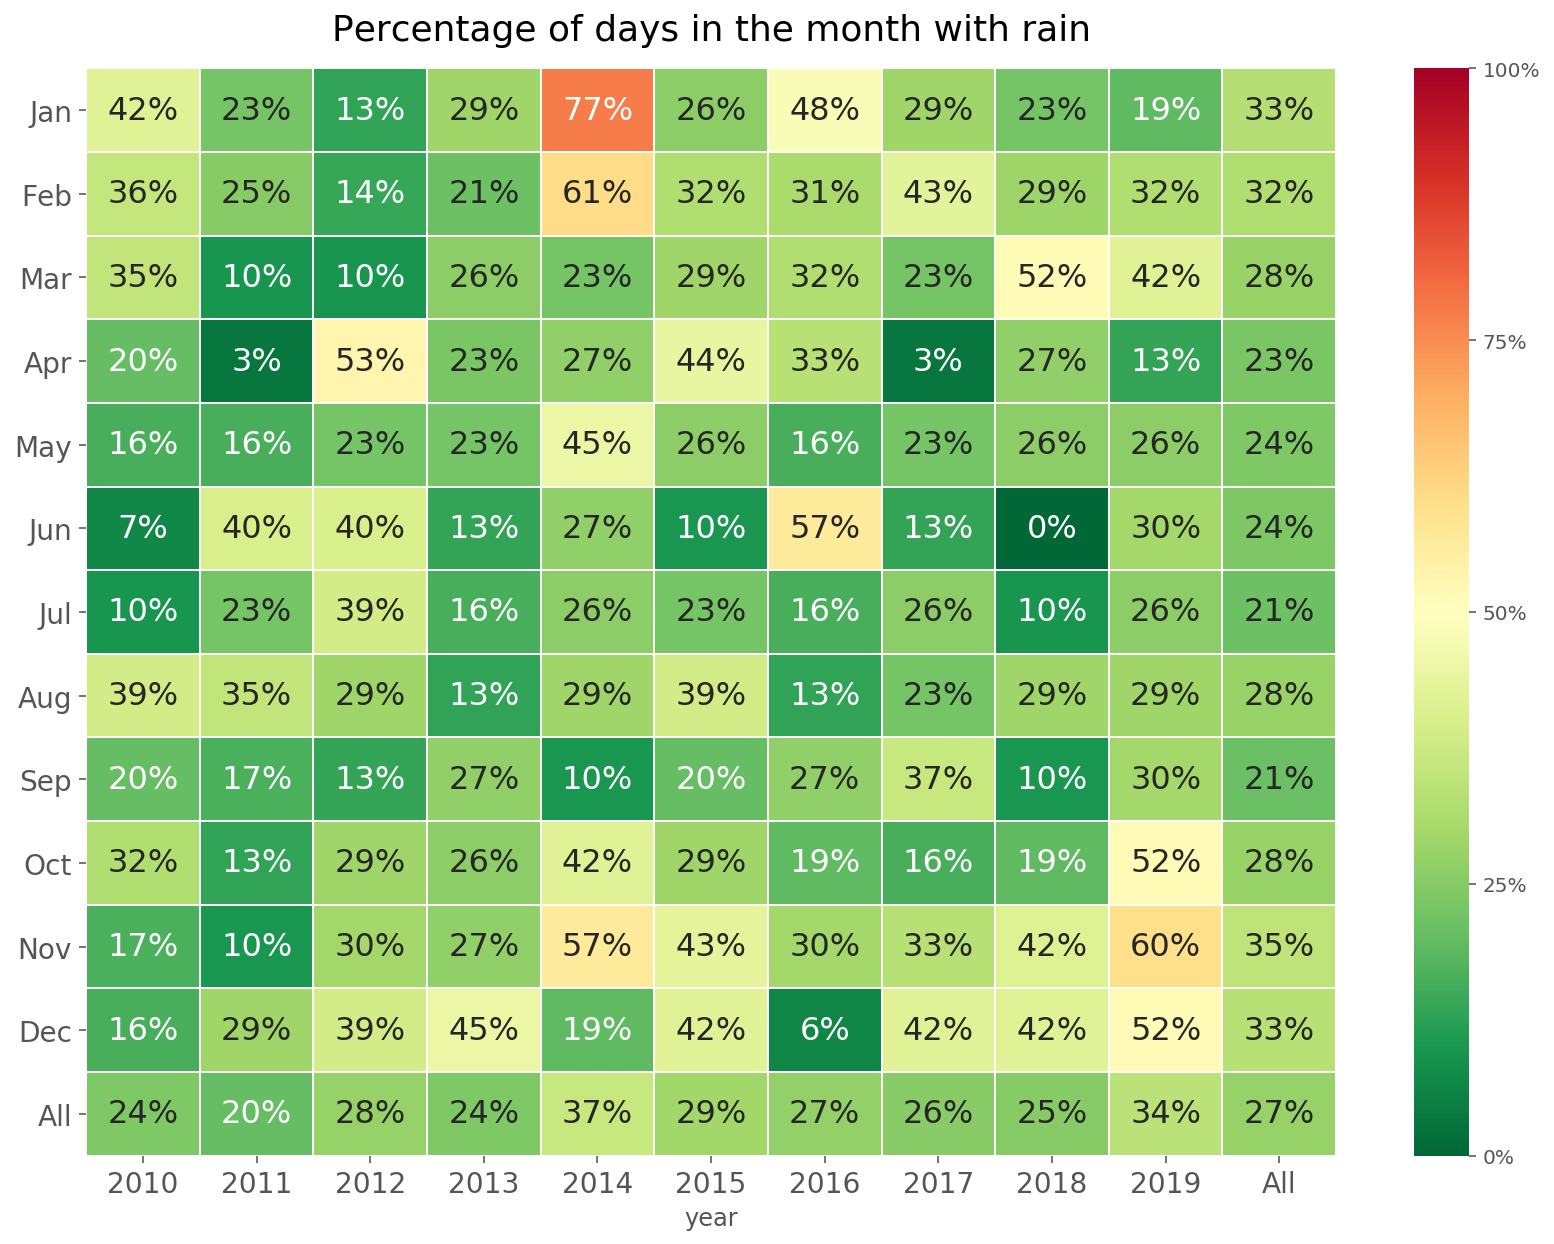

In [80]:
plt.figure(figsize = (14, 10))
ax = sns.heatmap(all_month_year_percentage_df, cmap = 'RdYlGn_r', annot=True, fmt='.0%',
                 vmin=0, vmax=1, linewidths=.5, annot_kws={"size": 16})
cbar = ax.collections[0].colorbar
cbar.set_ticks([0, .25, .50,.75, 1])
cbar.set_ticklabels(['0%', '25%', '50%', '75%', '100%'])
ax.set_yticklabels(ax.get_yticklabels(), rotation = 0, fontsize = 14)
ax.set_xticklabels(ax.get_xticklabels(), rotation = 0, fontsize = 14)
ax.tick_params(rotation = 0)
plt.title('Percentage of days in the month with rain', fontdict={'fontsize':18}, pad=14);

In a similar fashion we can create an aggregation for each day of the year.

In [81]:
def plot_heatmap_year(year):
    plt.figure(figsize = (16, 10))
    allByYear_df = df.loc[df['year'] == year]
    allByYear_df = pd.pivot_table(allByYear_df, values="precipitation",
                                  index=["month"], columns=["day"], fill_value=None)
    allByYear_df = allByYear_df.set_index([[calendar.month_abbr[i] for i in list(allByYear_df.index)]])
    ax = sns.heatmap(allByYear_df, cmap = 'RdYlGn_r',
                     vmin=0, vmax=20,
                     annot=False, linewidths=.1,
                     annot_kws={"size": 8}, square=True, cbar_kws={"shrink": .48, 'label': 'Rain (mm)'})
    ax.set_yticklabels(ax.get_yticklabels(), rotation = 0, fontsize = 12)
    ax.set_xticklabels(ax.get_xticklabels(), rotation = 0, fontsize = 12)
    ax.tick_params(rotation = 0)
    plt.title(f'Precipitations {year}', fontdict={'fontsize':18}, pad=14);

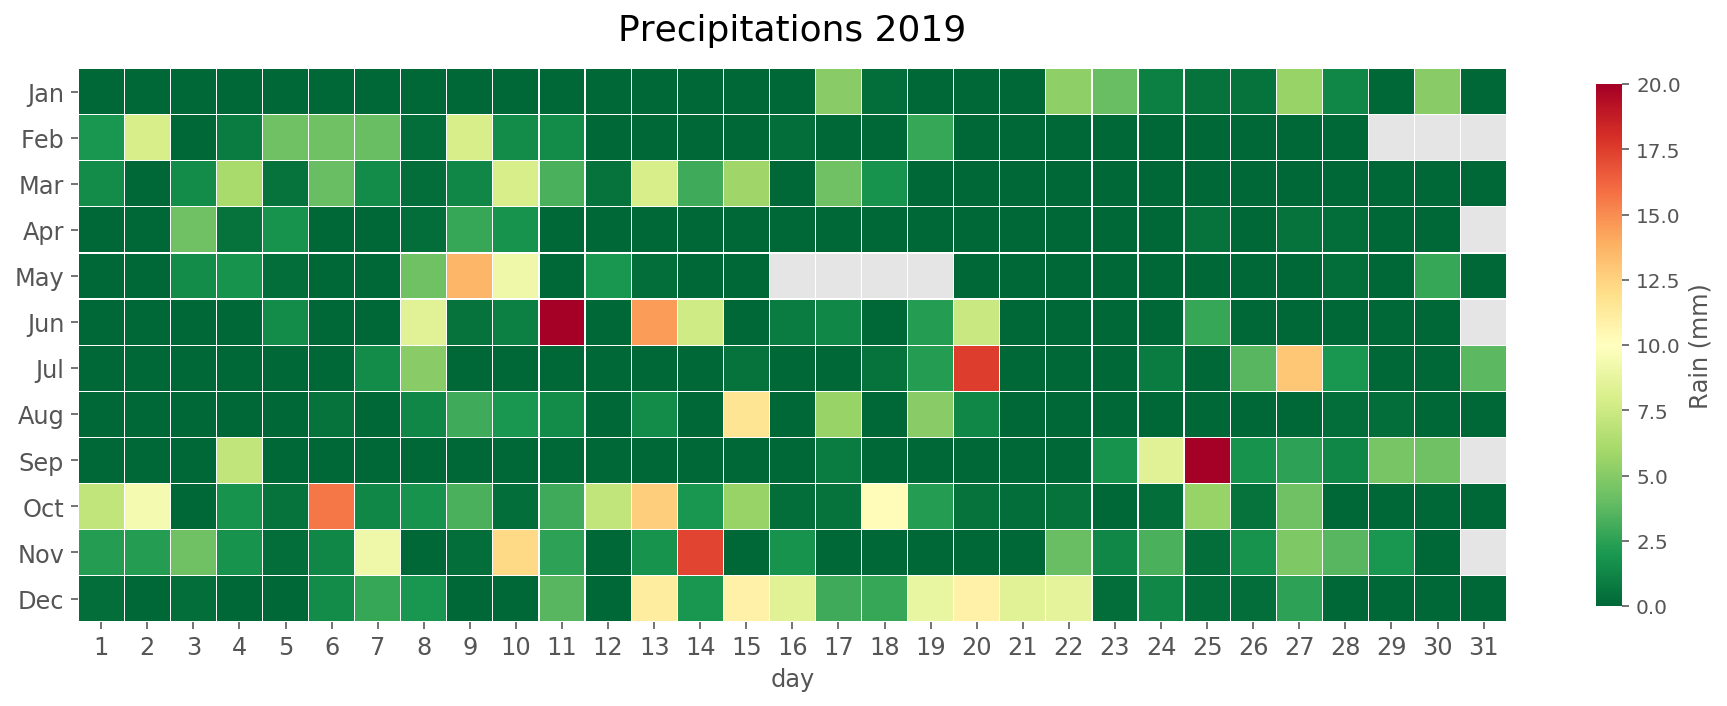

In [82]:
plot_heatmap_year(2019)

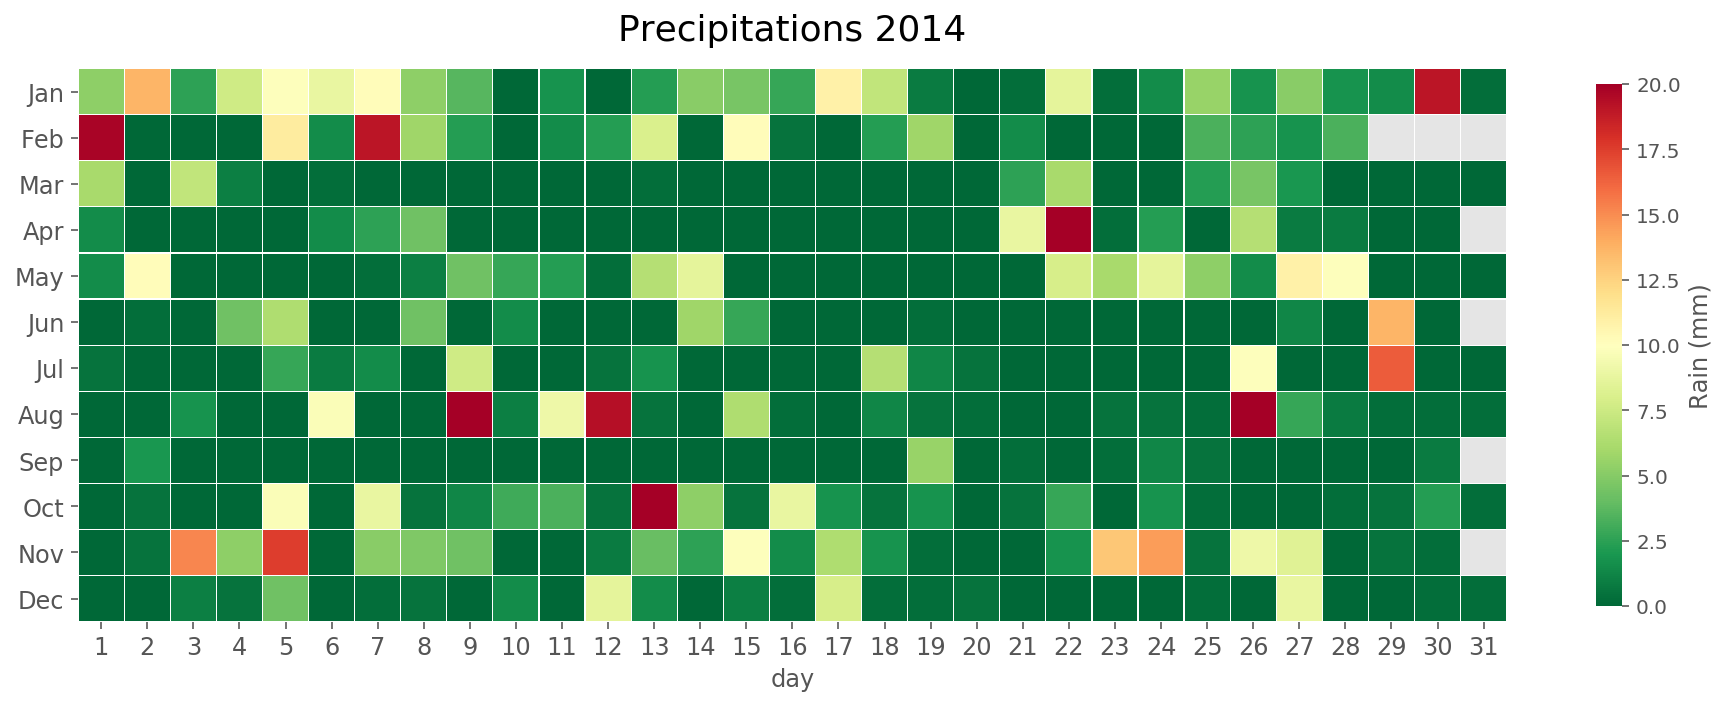

In [83]:
plot_heatmap_year(2014)

In [84]:
all_days_avg_df = df.groupby([df.date.dt.month, df.date.dt.day])['precipitation'].mean()
all_days_avg_df = all_days_avg_df.unstack()
all_days_avg_df = all_days_avg_df.set_index([[calendar.month_abbr[i] for i in list(all_days_avg_df.index)]])

Another possibility is to get the mean precipitation for each day of the year considering all the years in the dataset.
In the heatmap a custom colormap was used in order to have greenish cells for very low values.

In [85]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

def make_colormap(seq):
    """
    Return a LinearSegmentedColormap
    seq: list
        a sequence of floats and RGB-tuples. 
        The floats should be increasing and in the interval (0,1).
    """
    seq = [(None,) * 3, 0.0] + list(seq) + [1.0, (None,) * 3]
    cdict = {'red': [], 'green': [], 'blue': []}
    for i, item in enumerate(seq):
        if isinstance(item, float):
            r1, g1, b1 = seq[i - 1]
            r2, g2, b2 = seq[i + 1]
            cdict['red'].append([item, r1, r2])
            cdict['green'].append([item, g1, g2])
            cdict['blue'].append([item, b1, b2])
    return mcolors.LinearSegmentedColormap('CustomMap', cdict)

In [86]:
import matplotlib.colors as colors
c = colors.ColorConverter().to_rgb
gyr = make_colormap([c('green'), c('yellow'), 0.25, c('yellow'), c('red')])

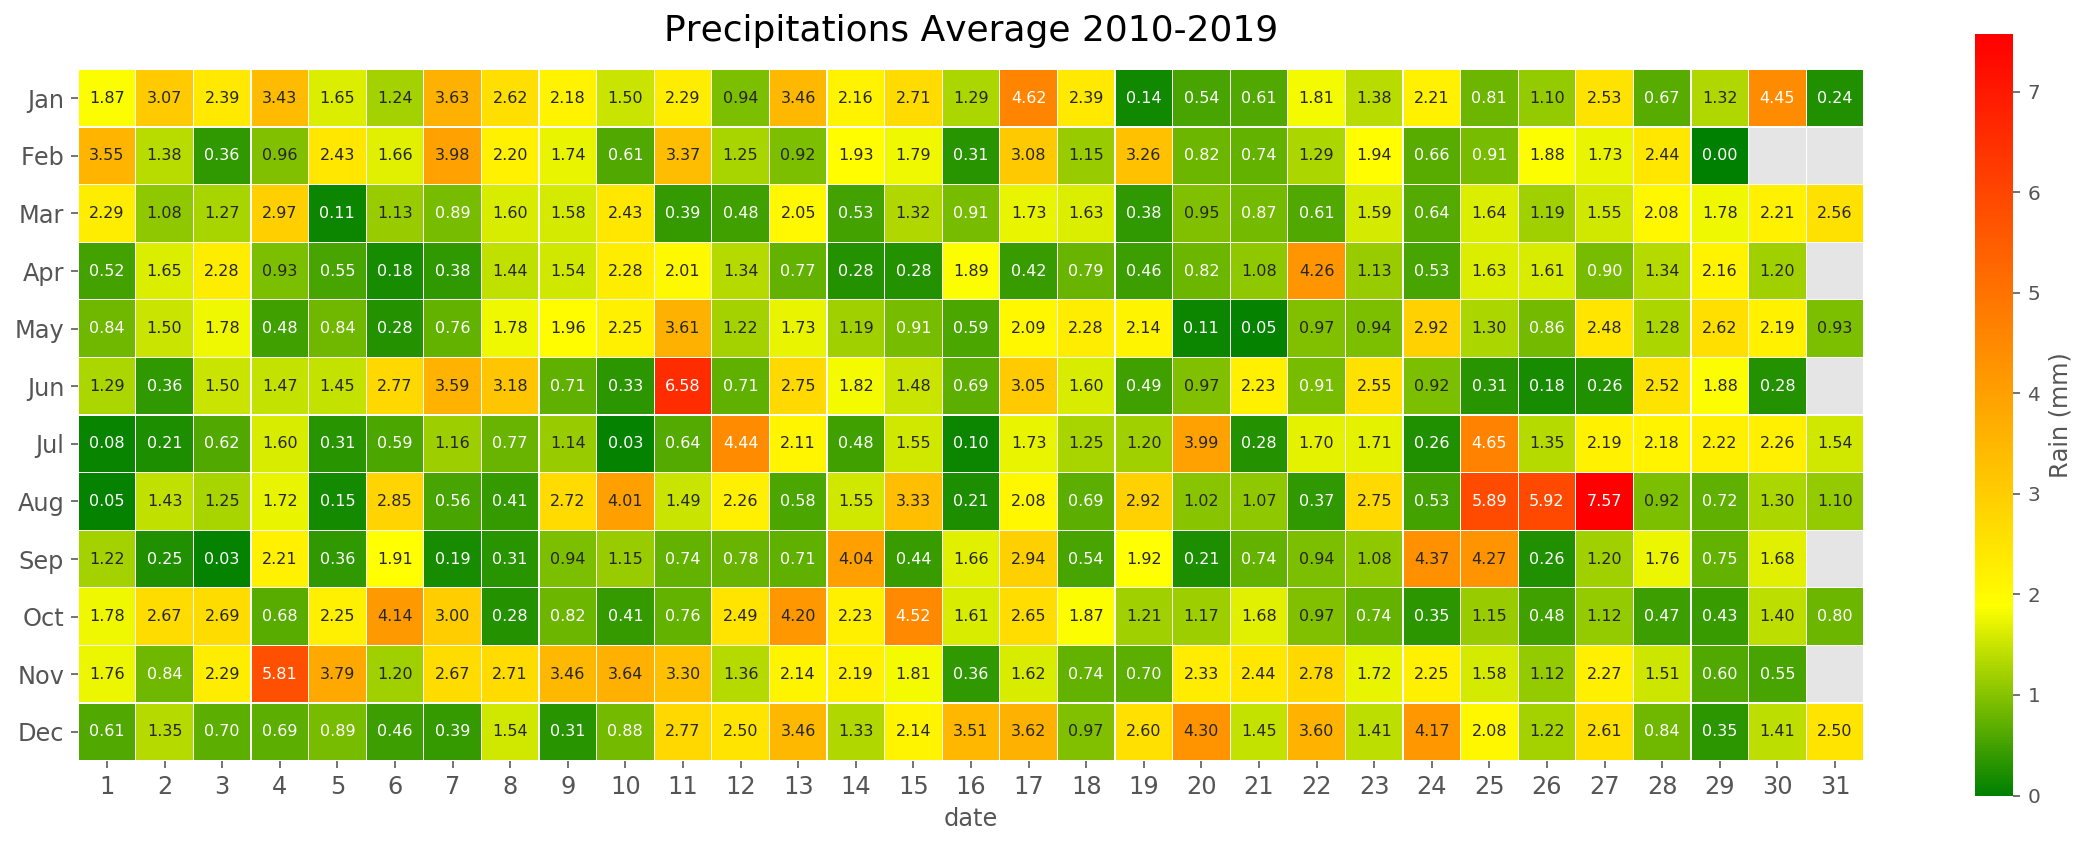

In [87]:
plt.figure(figsize = (20, 14))
ax = sns.heatmap(all_days_avg_df, cmap = gyr, annot=True, fmt='.2f',
                 vmin=0, linewidths=.1,
                 annot_kws={"size": 8}, square=True,  # <-- square cell
                 cbar_kws={"shrink": .5, 'label': 'Rain (mm)'})
ax.set_yticklabels(ax.get_yticklabels(), rotation = 0, fontsize = 12)
ax.set_xticklabels(ax.get_xticklabels(), rotation = 0, fontsize = 12)
ax.tick_params(rotation = 0)
_ = plt.title('Precipitations Average 2010-2019', fontdict={'fontsize':18}, pad=14)

Another way to customize the colormap to make highest values more prominent.

In [88]:
custom_palette = sns.color_palette("GnBu", 6)
custom_palette[5] = sns.color_palette("OrRd", 6)[5]

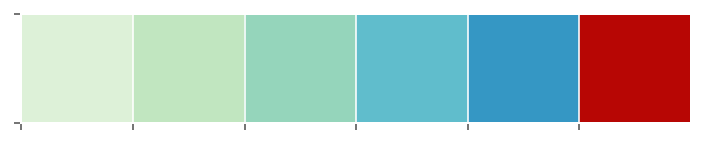

In [89]:
sns.palplot(custom_palette)

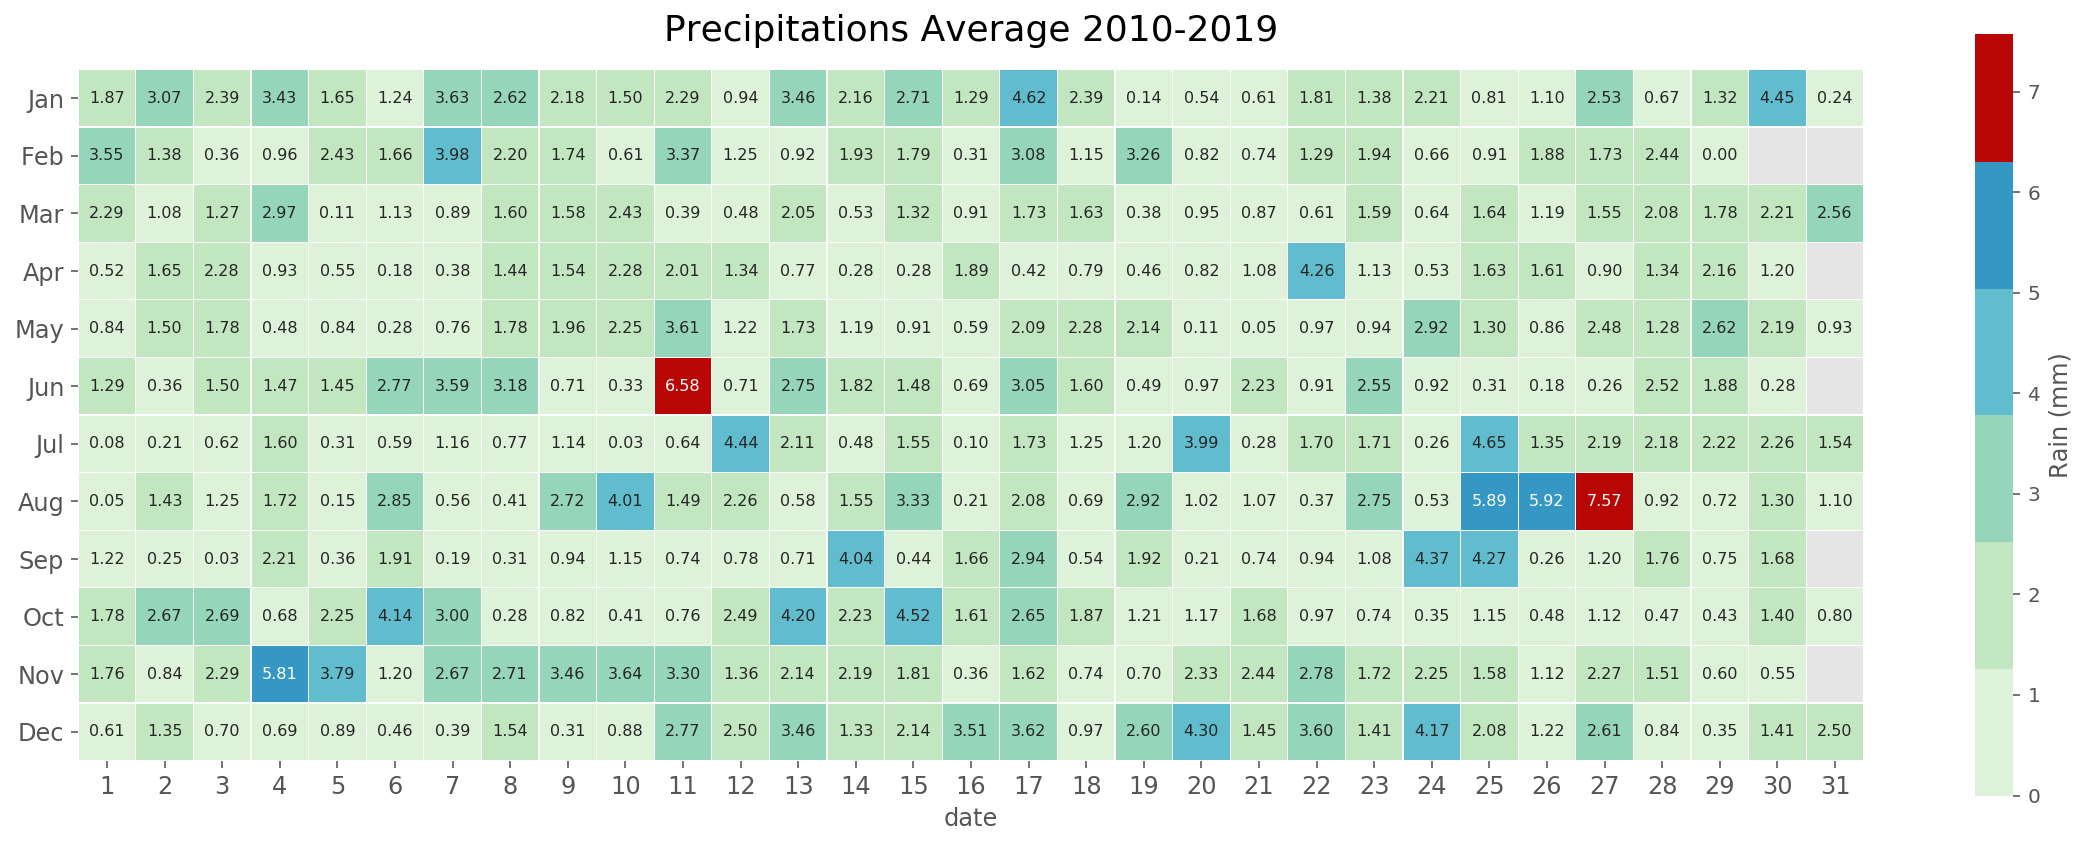

In [90]:
plt.figure(figsize = (20, 14))
ax = sns.heatmap(all_days_avg_df, cmap = custom_palette, annot=True, fmt='.2f',
                 vmin=0, linewidths=.1,
                 annot_kws={"size": 8}, square=True,
                 cbar_kws={"shrink": .5, 'label': 'Rain (mm)'})
ax.set_yticklabels(ax.get_yticklabels(), rotation = 0, fontsize = 12)
ax.set_xticklabels(ax.get_xticklabels(), rotation = 0, fontsize = 12)
ax.tick_params(rotation = 0)
_ = plt.title('Precipitations Average 2010-2019', fontdict={'fontsize':18}, pad=14)

### CountPlot with customized text

In [91]:
df.groupby('year')['raining'].sum()

year
2010     88
2011     74
2012    101
2013     88
2014    134
2015    101
2016    100
2017     94
2018     91
2019    124
Name: raining, dtype: int64

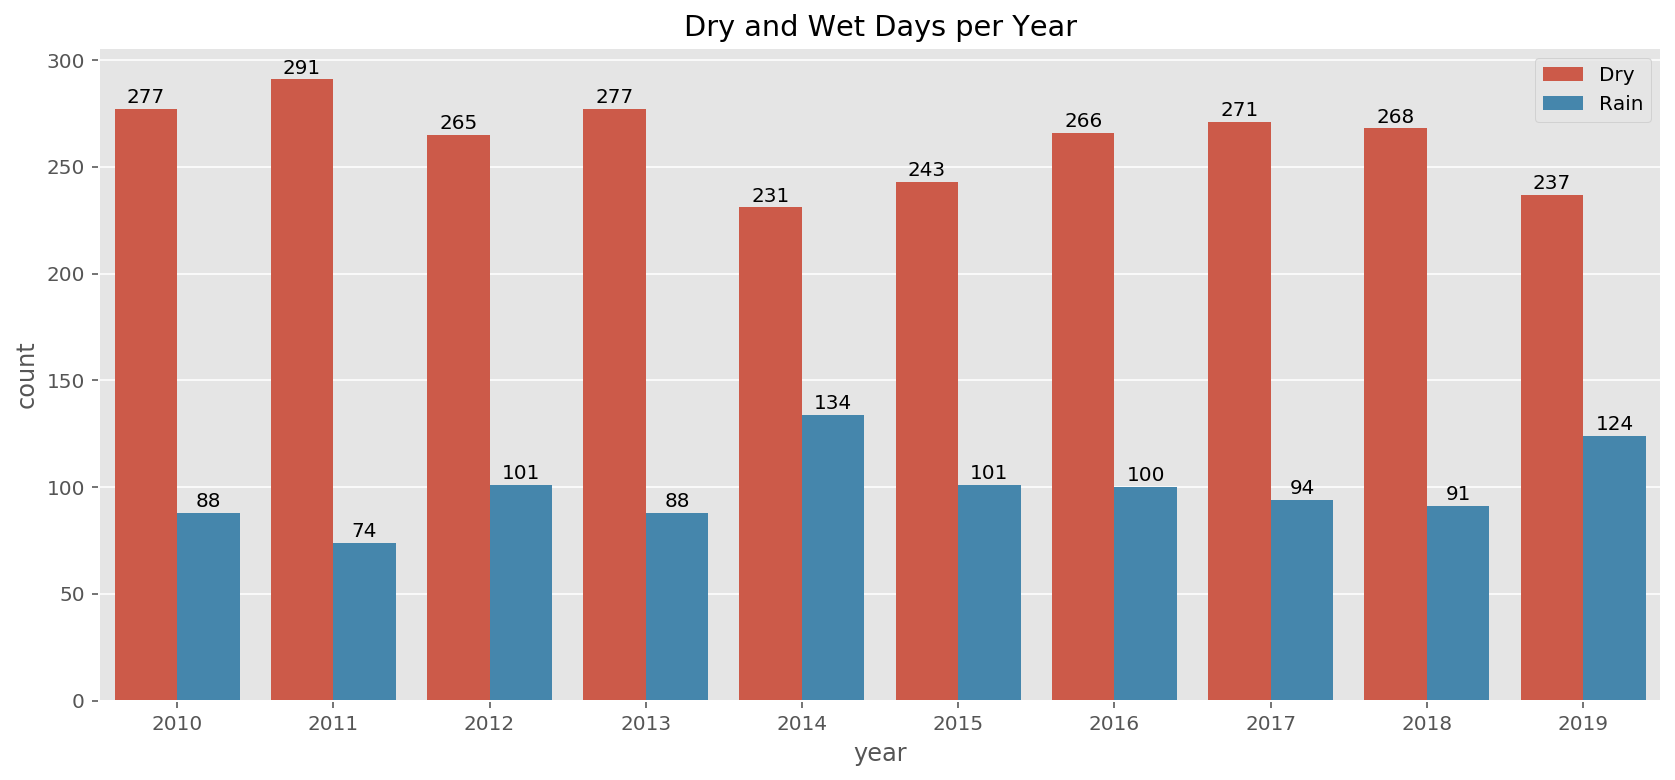

In [92]:
plt.figure(figsize = (14, 6))
ax = sns.countplot(x="year", hue="raining", data=df.sort_values(by='year'))
ax.legend(loc='upper right', frameon=True, labels=['Dry', 'Rain'])

for p in ax.patches:
    ax.annotate(format(p.get_height()),
                (p.get_x()+p.get_width()/2., p.get_height()-4),
                ha = 'center', va = 'center',
                xytext = (0, 10), textcoords = 'offset points')

_ = ax.set_title("Dry and Wet Days per Year")

Something that may be needed when analyzing time series is to calculate the number of consecutive days satisfying a specific condition.
In this case we can try to find the longest spells of dry and rainy days.
One way to do so is to use a combination of diff, cumsum and groupby.
First we need to label each row with an increasing number per each spell.

In [93]:
df['value_grp'] = (df['raining'].diff() != 0).astype('int').cumsum()

In [94]:
(df['raining'].diff() != 0).astype('int')

0       1
1       0
2       0
3       0
4       0
       ..
3616    1
3617    1
3618    0
3619    0
3620    0
Name: raining, Length: 3621, dtype: int64

In [95]:
df.head(10)[['date', 'precipitation', 'raining', 'value_grp']]

,date,precipitation,raining,value_grp
0,2010-01-01,0.0,0,1
1,2010-01-02,0.0,0,1
2,2010-01-03,0.0,0,1
3,2010-01-04,0.0,0,1
4,2010-01-05,0.3,0,1
5,2010-01-06,1.5,1,2
6,2010-01-07,3.0,1,2
7,2010-01-08,1.0,0,3
8,2010-01-09,0.3,0,3
9,2010-01-10,0.0,0,3


Then we can create a new DataFrame with a row for each label using groupby.

In [96]:
grouped_values = df.groupby('value_grp')
consecutive_df = pd.DataFrame({'BeginDate' : grouped_values.date.first(), 
              'EndDate' : grouped_values.date.last(),
              'Consecutive' : grouped_values.size(),
              'condition': grouped_values.raining.max() }).reset_index(drop=True)
consecutive_df['condition'].replace({0: 'Dry', 1: 'Rain'}, inplace=True)
consecutive_df.sort_values(by='Consecutive', ascending=False).head(10)

,BeginDate,EndDate,Consecutive,condition
974,2018-05-31,2018-07-27,58,Dry
52,2010-06-10,2010-07-14,35,Dry
836,2017-03-24,2017-04-26,34,Dry
132,2011-04-06,2011-05-06,31,Dry
196,2011-11-06,2011-11-30,25,Dry
114,2011-01-19,2011-02-10,23,Dry
1026,2018-12-25,2019-01-16,23,Dry
432,2013-11-22,2013-12-13,22,Dry
1060,2019-04-11,2019-05-02,22,Dry
388,2013-07-04,2013-07-24,21,Dry


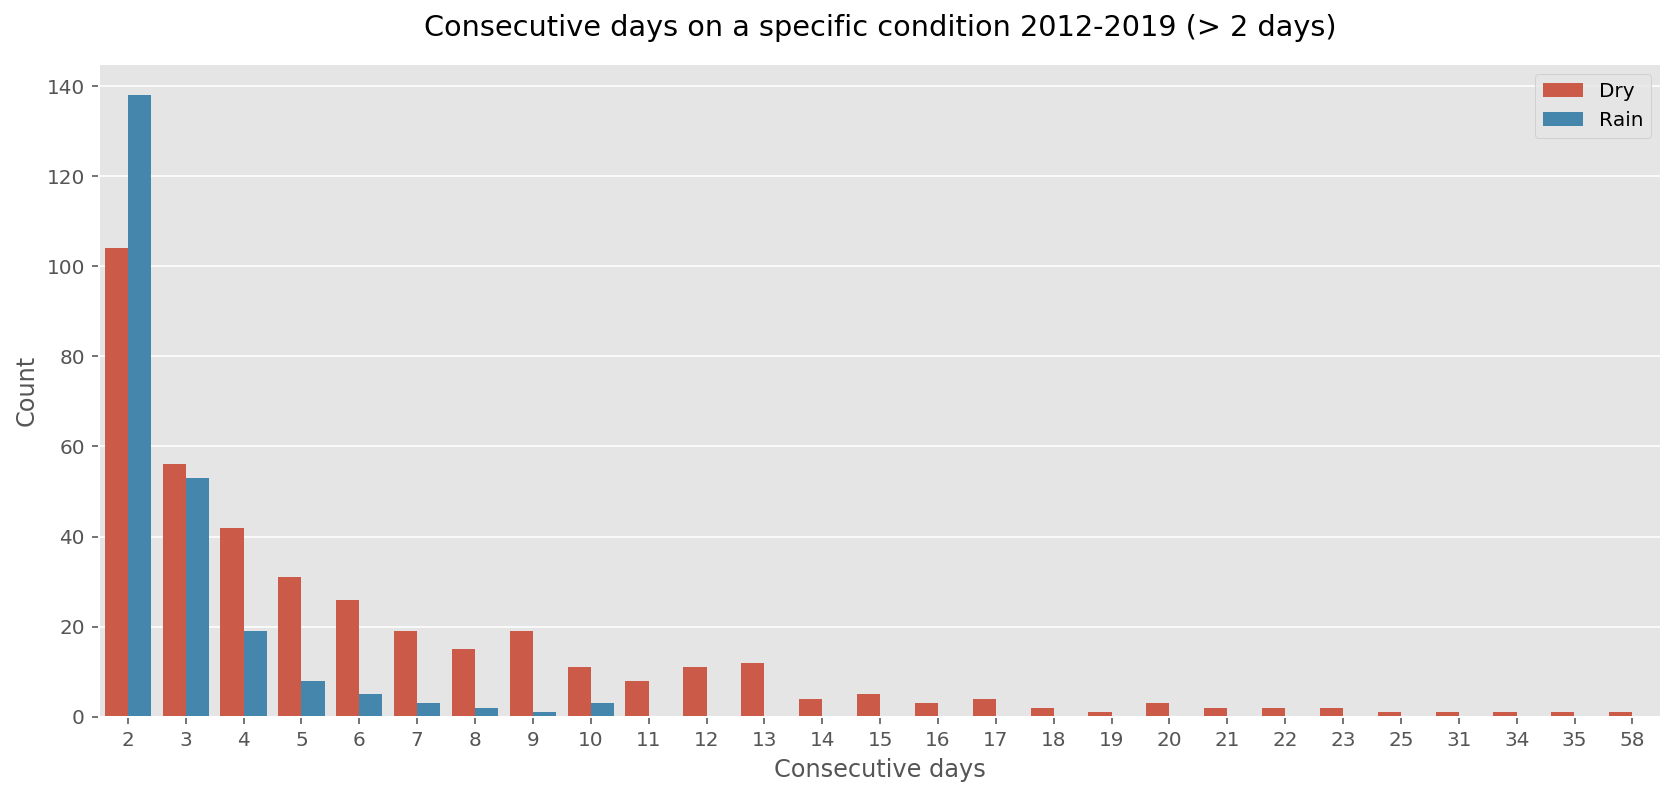

In [97]:
plt.figure(figsize = (14, 6))
ax = sns.countplot(x='Consecutive', hue='condition', data=consecutive_df.query('Consecutive >= 2'))
ax.set_title('Consecutive days on a specific condition 2012-2019 (> 2 days)', pad=14)
ax.set(xlabel='Consecutive days', ylabel='Count')
_ = plt.legend(loc='upper right')

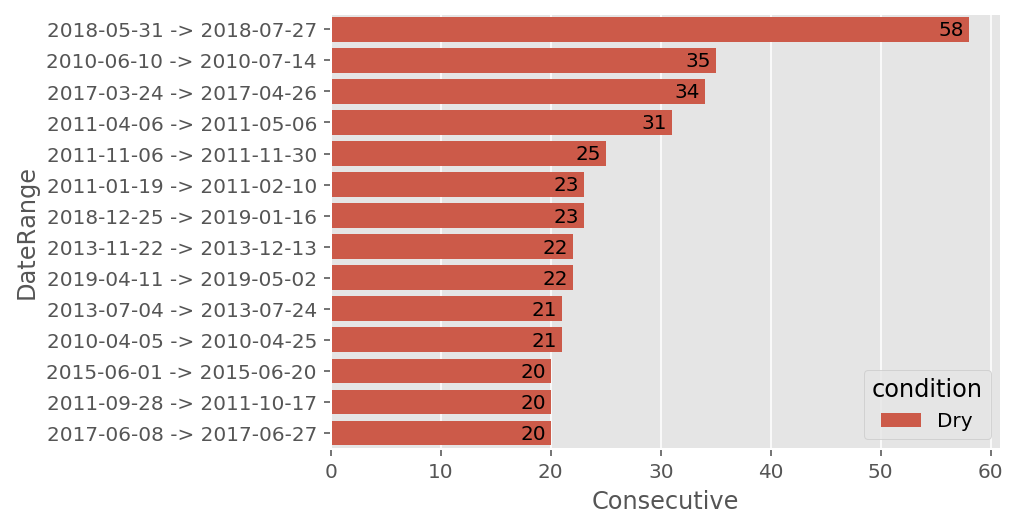

In [98]:
consecutive_df['DateRange'] = consecutive_df["BeginDate"].astype(str) + ' -> ' + consecutive_df["EndDate"].astype(str)
ax = sns.barplot(x="Consecutive", y="DateRange", hue="condition", data=consecutive_df.sort_values(by='Consecutive', ascending=False).head(14))

for p in ax.patches:
 width = p.get_width()
 ax.text(width -1.6, p.get_y() + p.get_height()/2. + 0.2,'{:1.0f}'.format(width), ha="center")

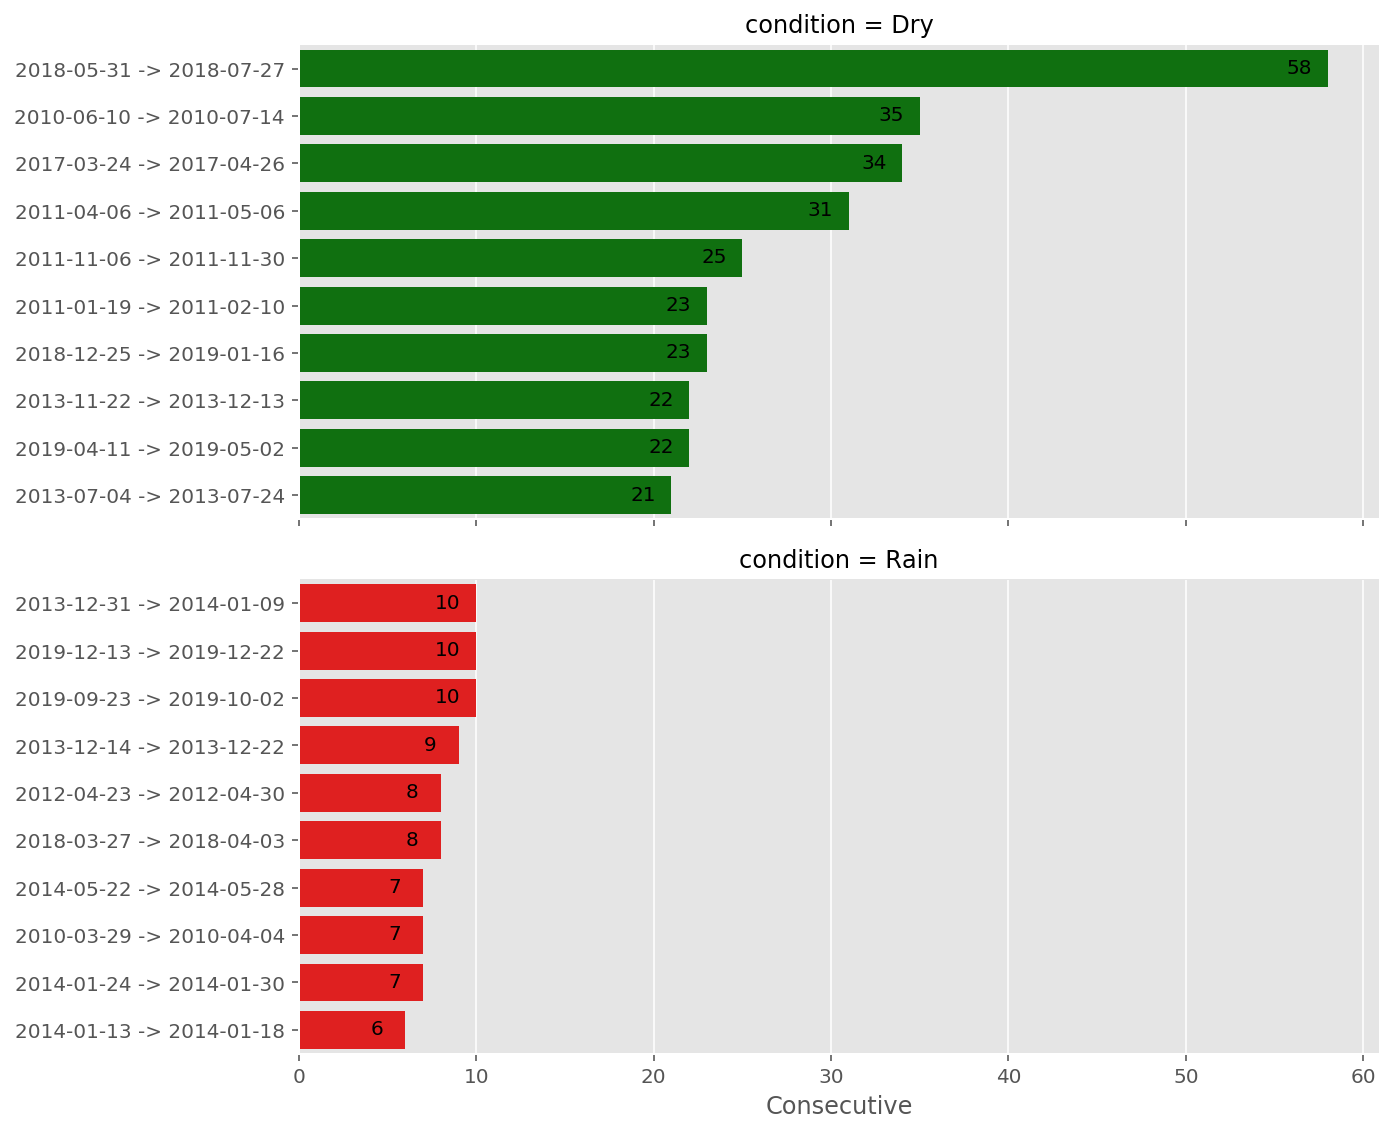

In [99]:
df_top10_per_condition = consecutive_df.sort_values(by='Consecutive',ascending = False).groupby('condition').head(10)

d = {'color': ['g', 'r']}
g = sns.FacetGrid(df_top10_per_condition, row="condition",
                      hue='condition',
                      hue_kws=d,
                      sharey=False)

g.fig.set_figheight(8)
g.fig.set_figwidth(10)
    
_ = g.map(sns.barplot, "Consecutive", "DateRange")
_ = g.set(ylabel='')

# This is just to add the numbers inside the bars
for ax in g.axes.flat:
 for p in ax.patches:
  width = p.get_width()
  _ = ax.text(width -1.6, p.get_y() + p.get_height()/2. + 0.1,'{:1.0f}'.format(width), ha="center")

Create custom palette to use blue for high precipitation values

In [100]:
custom_palette = sns.diverging_palette(128, 240, n=10)

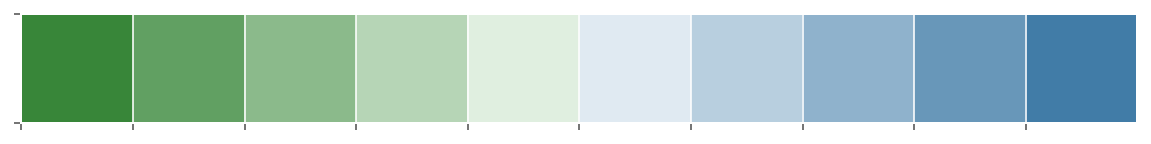

In [101]:
sns.palplot(custom_palette)

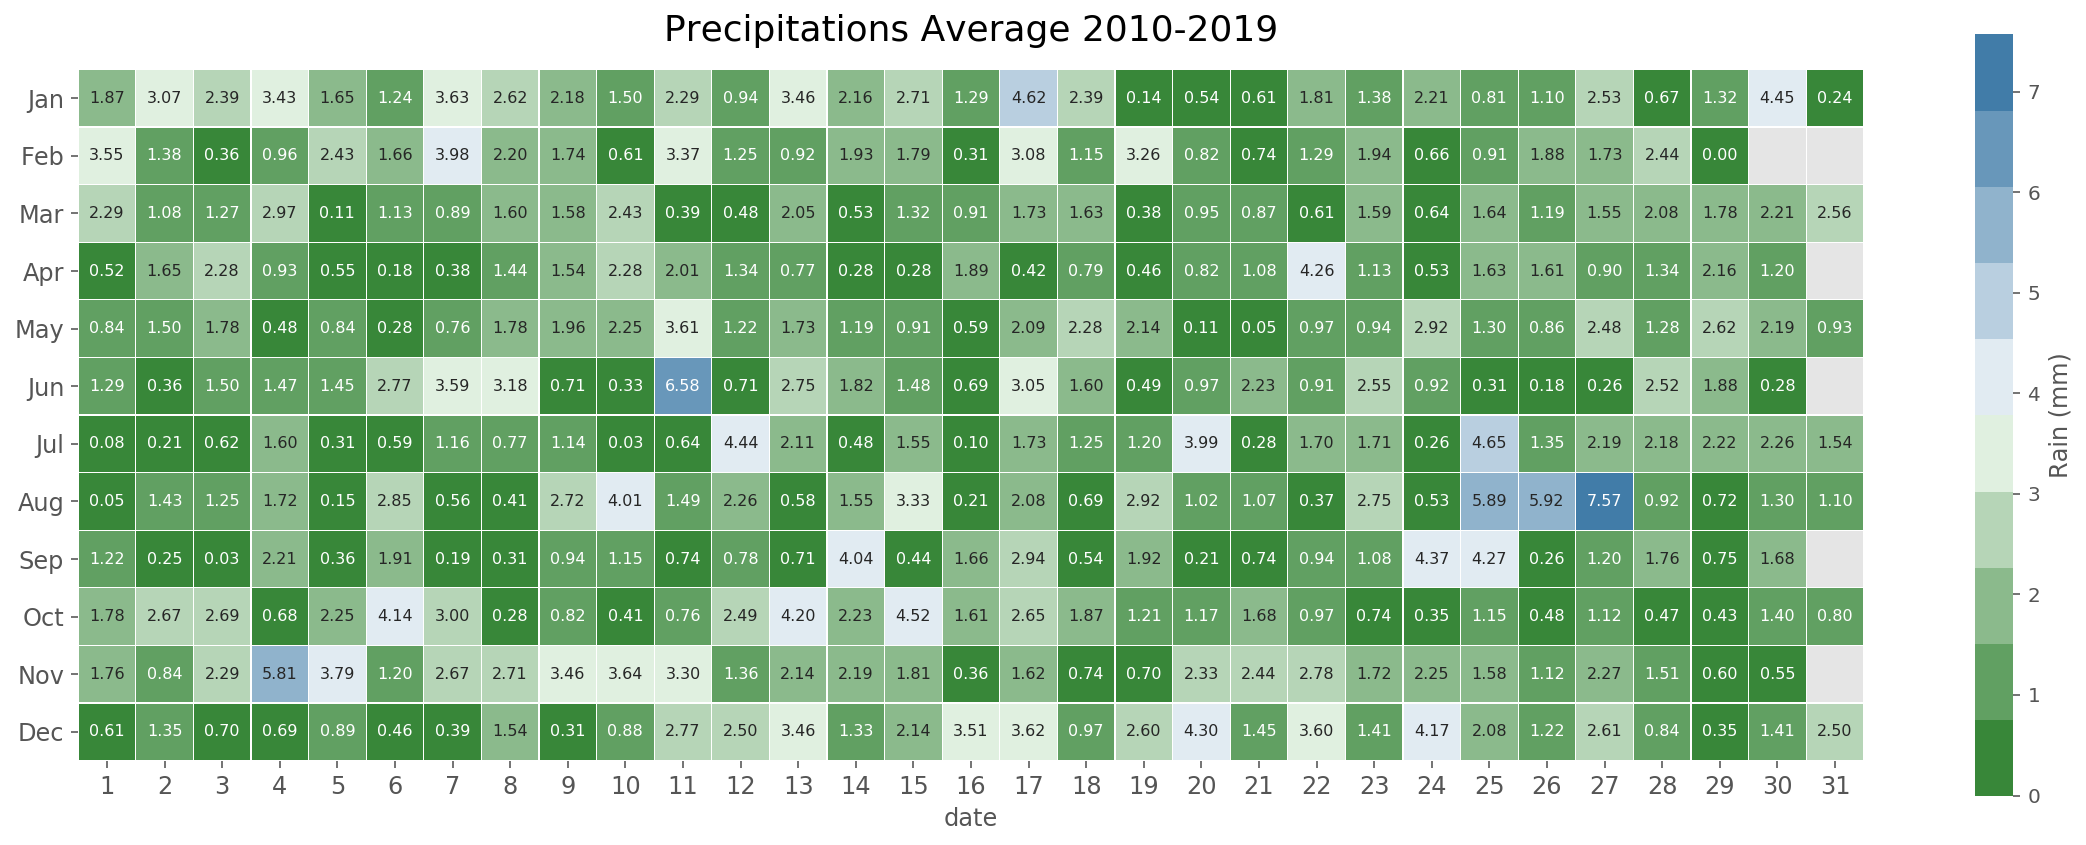

In [102]:
plt.figure(figsize = (20, 14))
ax = sns.heatmap(all_days_avg_df, cmap = custom_palette, annot=True, fmt='.2f',
                 vmin=0, linewidths=.1,
                 annot_kws={"size": 8}, square=True,
                 cbar_kws={"shrink": .5, 'label': 'Rain (mm)'})
ax.set_yticklabels(ax.get_yticklabels(), rotation = 0, fontsize = 12)
ax.set_xticklabels(ax.get_xticklabels(), rotation = 0, fontsize = 12)
ax.tick_params(rotation = 0)
_ = plt.title('Precipitations Average 2010-2019', fontdict={'fontsize':18}, pad=14)

Running average to identify periods with high precipitations.

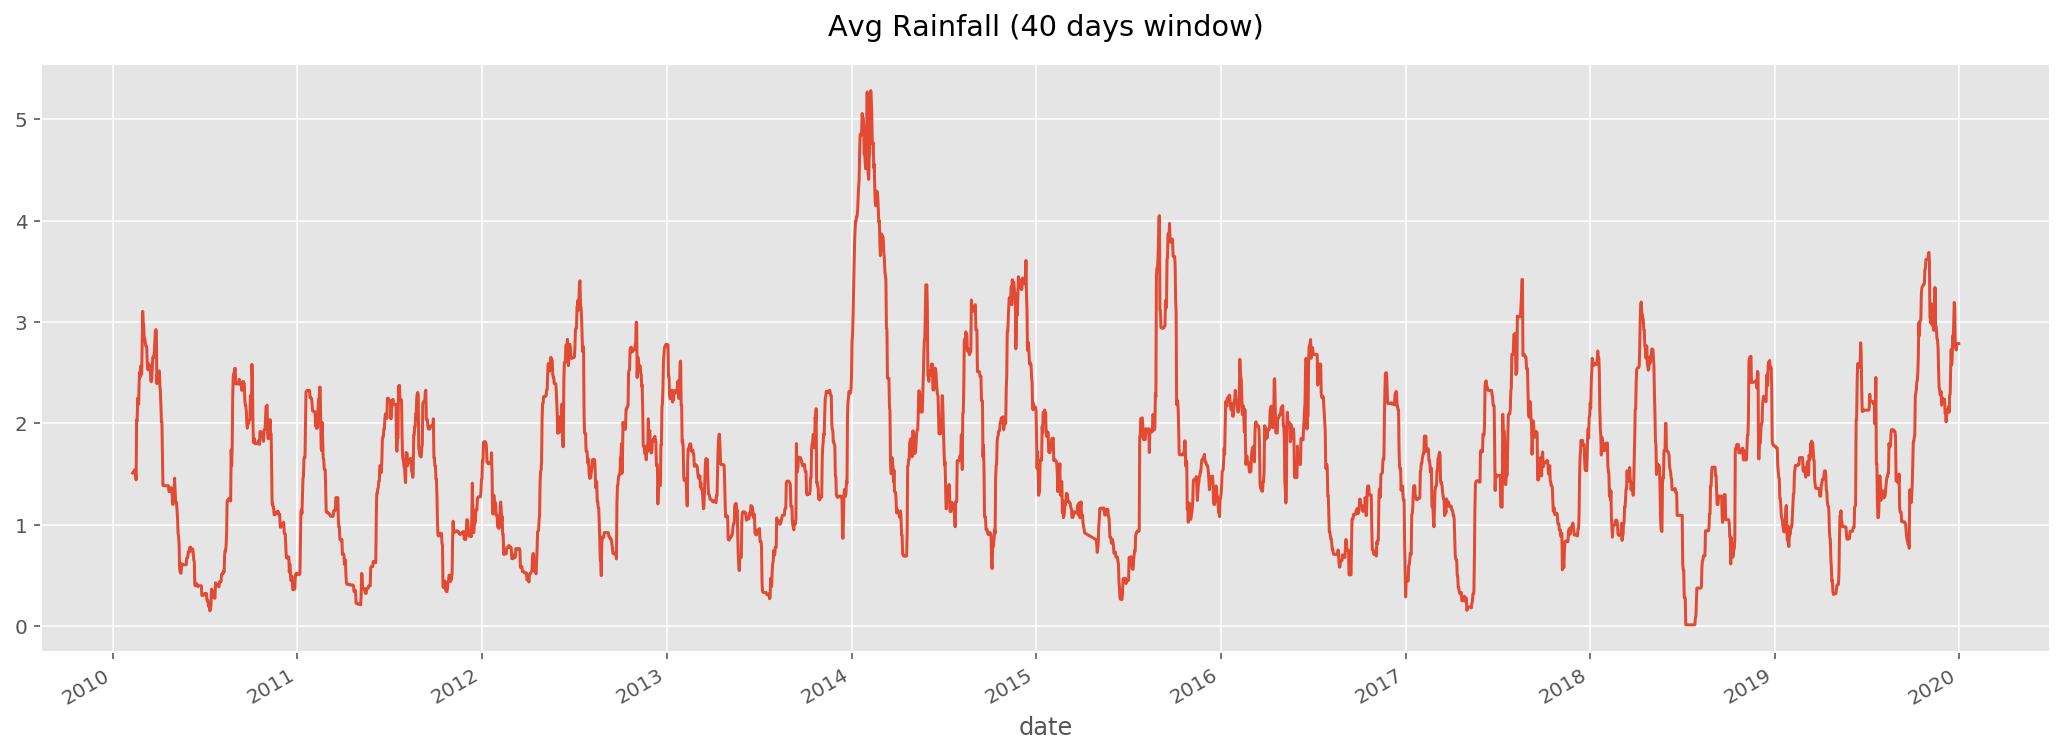

In [103]:
plt.figure(figsize = (18, 6))
plt.title('Avg Rainfall (40 days window)', pad=14)
_ = df.set_index('date')['precipitation'].rolling(40).mean().plot()

Experimenting with the average temperature

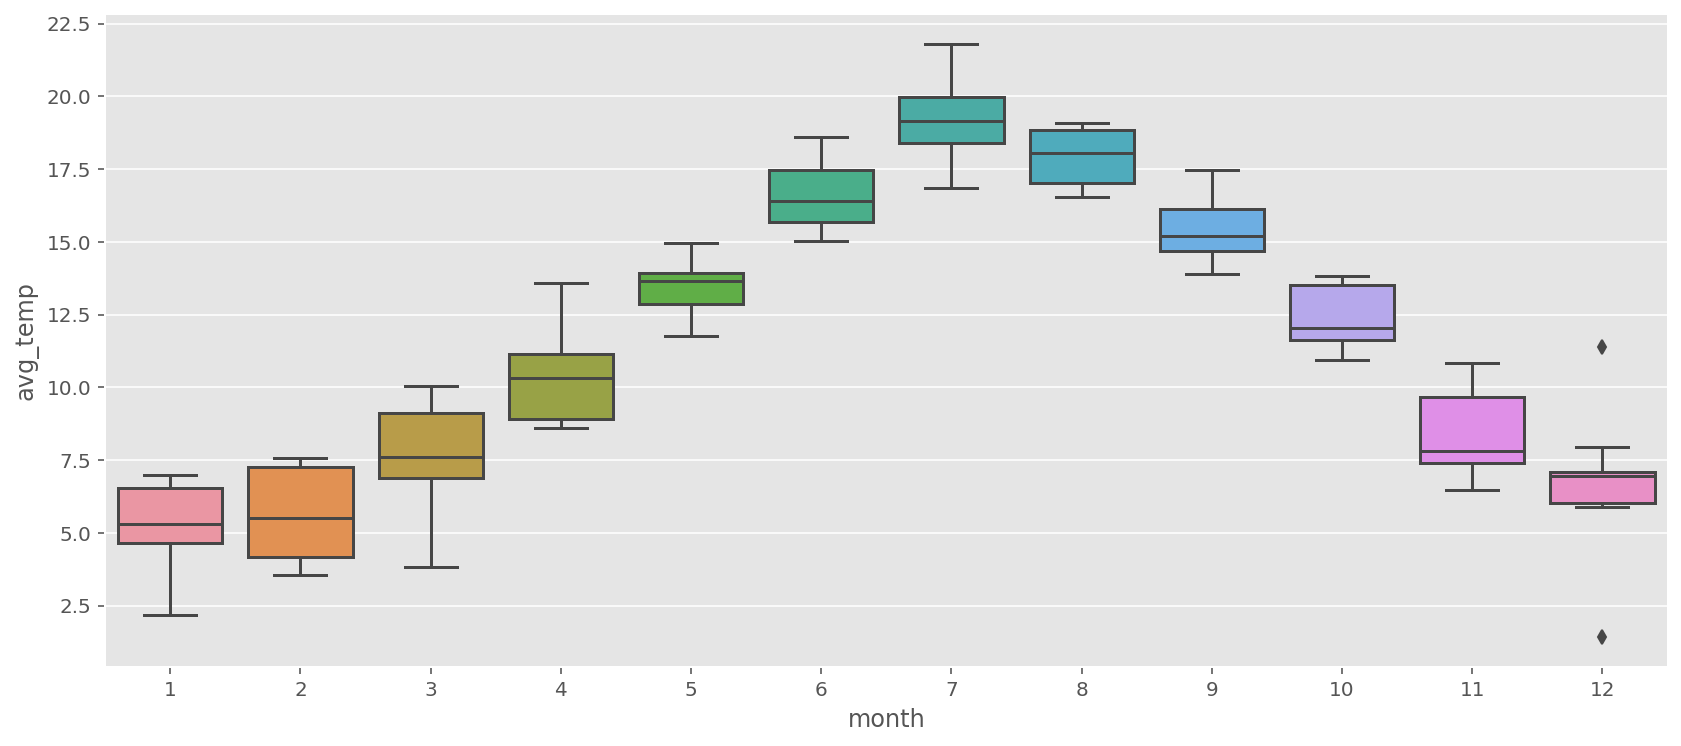

In [104]:
ops_month_df= df.groupby(['month', 'year']).mean()['avg_temp'].reset_index()
plt.figure(figsize = (14, 6))
ax = sns.boxplot(x = "month", y = "avg_temp", data = ops_month_df)

In [105]:
df.groupby(['month', 'year']).mean()['avg_temp'].reset_index()

,month,year,avg_temp
0,1,2010,2.183871
1,1,2011,5.083871
2,1,2012,6.593548
3,1,2013,4.551613
4,1,2014,7.006452
...,...,...,...
115,12,2015,11.374194
116,12,2016,6.883871
117,12,2017,5.990323
118,12,2018,7.941935


In [106]:
def plotHeatmap(df, title):
    plt.figure(figsize = (20, 8))

    ax = sns.heatmap(df, cmap = 'RdYlBu_r', fmt='.2f', annot=True,
                     linewidths=.2, annot_kws={"size": 8}, square=True,
                     cbar_kws={"shrink": .9, 'label': 'Temperature °C'})
    cbar = ax.collections[0].colorbar
    ax.set_yticklabels(ax.get_yticklabels(), rotation = 0, fontsize = 10)
    ax.set_xticklabels(ax.get_xticklabels(), rotation = 0, fontsize = 10)
    ax.tick_params(rotation = 0)
    plt.title(title, fontdict={'fontsize':18}, pad=14);

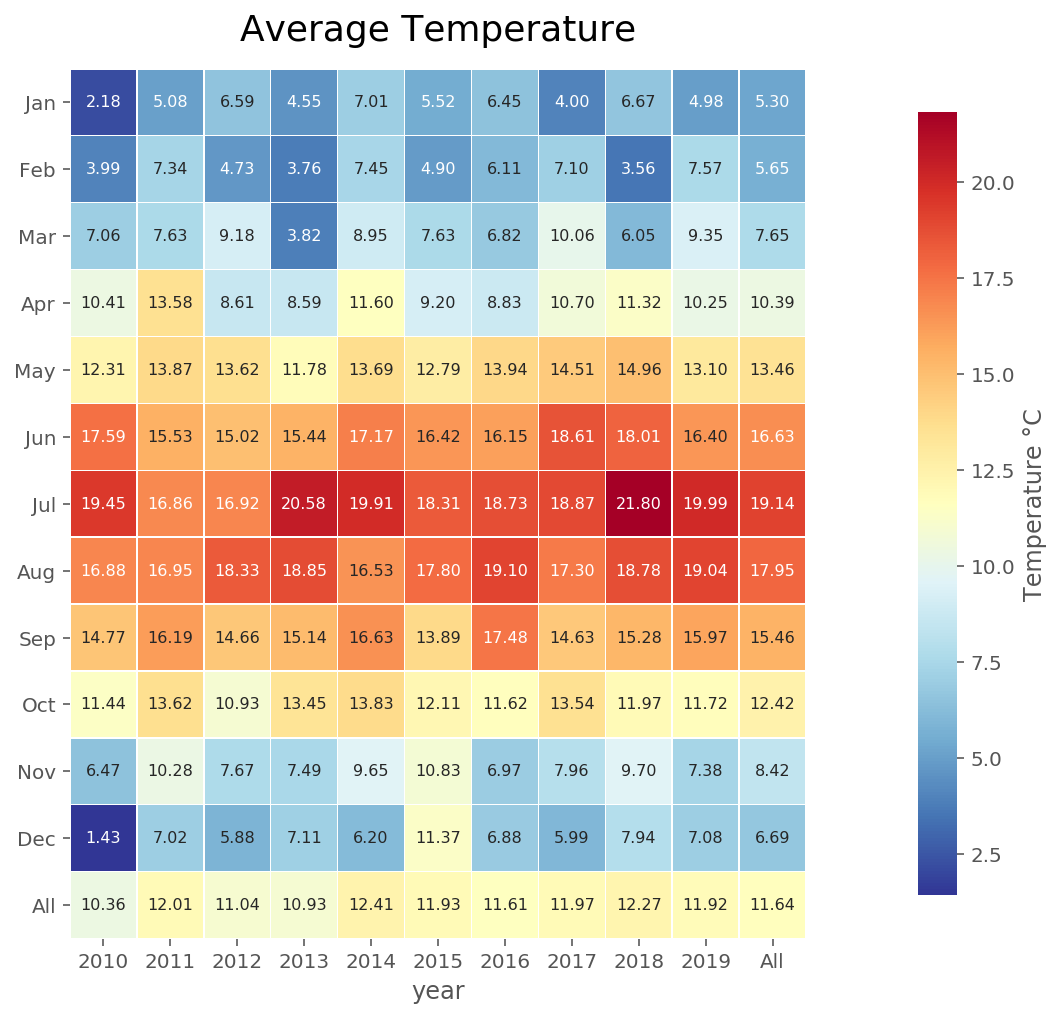

In [107]:
allMonthYear_df = pd.pivot_table(df, values="avg_temp",index=["month"], columns=["year"], fill_value=None, margins=True)
allMonthYear_df = allMonthYear_df.set_index([[calendar.month_abbr[i] if isinstance(i, int) else i for i in list(allMonthYear_df.index)]])
plotHeatmap(allMonthYear_df, 'Average Temperature')